In [87]:
import torch
torch.cuda.is_available()
print(torch.zeros(1).cuda())

tensor([0.], device='cuda:0')


In [9]:
import torch
import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_sparse import SparseTensor, matmul
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
print(torch_geometric.__version__)

import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType, OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

import networkx as nx
from deepsnap.hetero_graph import HeteroGraph
import copy
from copy import deepcopy
import pickle

import deepsnap
from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
from sklearn.metrics import f1_score, roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import json
from pathlib import Path as Data_Path
from os import listdir
from os.path import isfile, join
from itertools import combinations
from tqdm.notebook import tqdm

ModuleNotFoundError: No module named 'torch'

In [14]:
import graph_tool.all as gt
import json
print("graph-tool version: {}".format(gt.__version__.split(' ')[0]))

graph-tool version: 2.46


In [16]:
f = open('./CMPT-733-Project/mpd.slice.0-999.json')
data = json.load(f)
print(type(data))

<class 'dict'>


In [33]:
def json2graph(data_json):
    
    g = gt.Graph()
    #playlist attributes
    g.vp['pl_name'] = g.new_vertex_property('string')
    g.vp['pl_type'] = g.new_vertex_property('string')
    #track attributes
    g.vp['tr_uri'] = g.new_vertex_property('string')
    g.vp['tr_name'] = g.new_vertex_property('string')
    g.vp['tr_type'] = g.new_vertex_property('string')
    #artist attibutes
    g.vp['ar_uri'] = g.new_vertex_property('string')
    g.vp['ar_name'] = g.new_vertex_property('string')
    g.vp['ar_type'] = g.new_vertex_property('string')
    
    #add playlist nodes
    playlist_len=len(data_json['playlists'])
    playlist_attrs = []
    for playlist in data_json['playlists']:
        playlist_attrs.append({'pl_name': playlist['name'], 'pl_type': 'playlist'})
 
    for node_attrs in playlist_attrs:
        v1 = g.add_vertex()
        for key, value in node_attrs.items():
            g.vp[key][v1] = value
            
    #add track nodes
    track_attrs = []
    artist_attrs = []
    playlist_index=0
    edge_index=playlist_len
    artist_edge_list=[]
    playlist_edge_list=[]
    track_index_dict={}
    artist_track_dict={}
                               
    for playlist in data_json['playlists']:
        tracks_list = playlist['tracks']
        for track in tracks_list:
            dict_track={'tr_uri': track['track_uri'], 'tr_name': track['track_name'], 'tr_type': 'track'}
            if dict_track not in track_attrs:
                track_attrs.append(dict_track)
                track_index_dict[track['track_uri']]=edge_index
                edge_index+=1
            dict_artist={'ar_uri': track['artist_uri'], 'ar_name': track['artist_name'], 'ar_type': 'artist'}
            if dict_artist not in artist_attrs:
                artist_attrs.append(dict_artist)
                if track['artist_uri'] in artist_track_dict:
                    artist_track_dict[track['artist_uri']].add(track['track_uri'])
                else:
                    artist_track_dict[track['artist_uri']]={track['track_uri']}
            playlist_edge_list.append((playlist_index,edge_index))
            
        playlist_index+=1
    
  
    

    for node_attrs in track_attrs:
        v2 = g.add_vertex()
        for key, value in node_attrs.items():
            g.vp[key][v2] = value

    artist_index=edge_index
    for node_attrs in artist_attrs:
        v3 = g.add_vertex()
        for track in artist_track_dict[node_attrs['ar_uri']]:
            artist_edge_list.append((artist_index,track_index_dict[track]))
        for key, value in node_attrs.items():
            g.vp[key][v3] = value
        artist_index+=1
    g.add_edge_list(artist_edge_list)
    g.add_edge_list(playlist_edge_list)
    
    return g

def append_graphs(g1, g2):
    # Get the last vertex index from g1
    last_vindex = g1.num_vertices() - 1

    # Get vertex properties from g1
    vp1 = {key: g1.vp[key] for key in g1.vertex_properties.keys()}

    # Add vertex properties to g2
    for key, value in vp1.items():
        g2.vp[key] = g2.new_vertex_property(value.value_type())

    # Append vertices from g1 to g2 with new index
    for v in g1.vertices():
        new_v = g2.add_vertex()
        for key, value in vp1.items():
            g2.vp[key][new_v] = value[v]
        

In [34]:
G = json2graph(data)

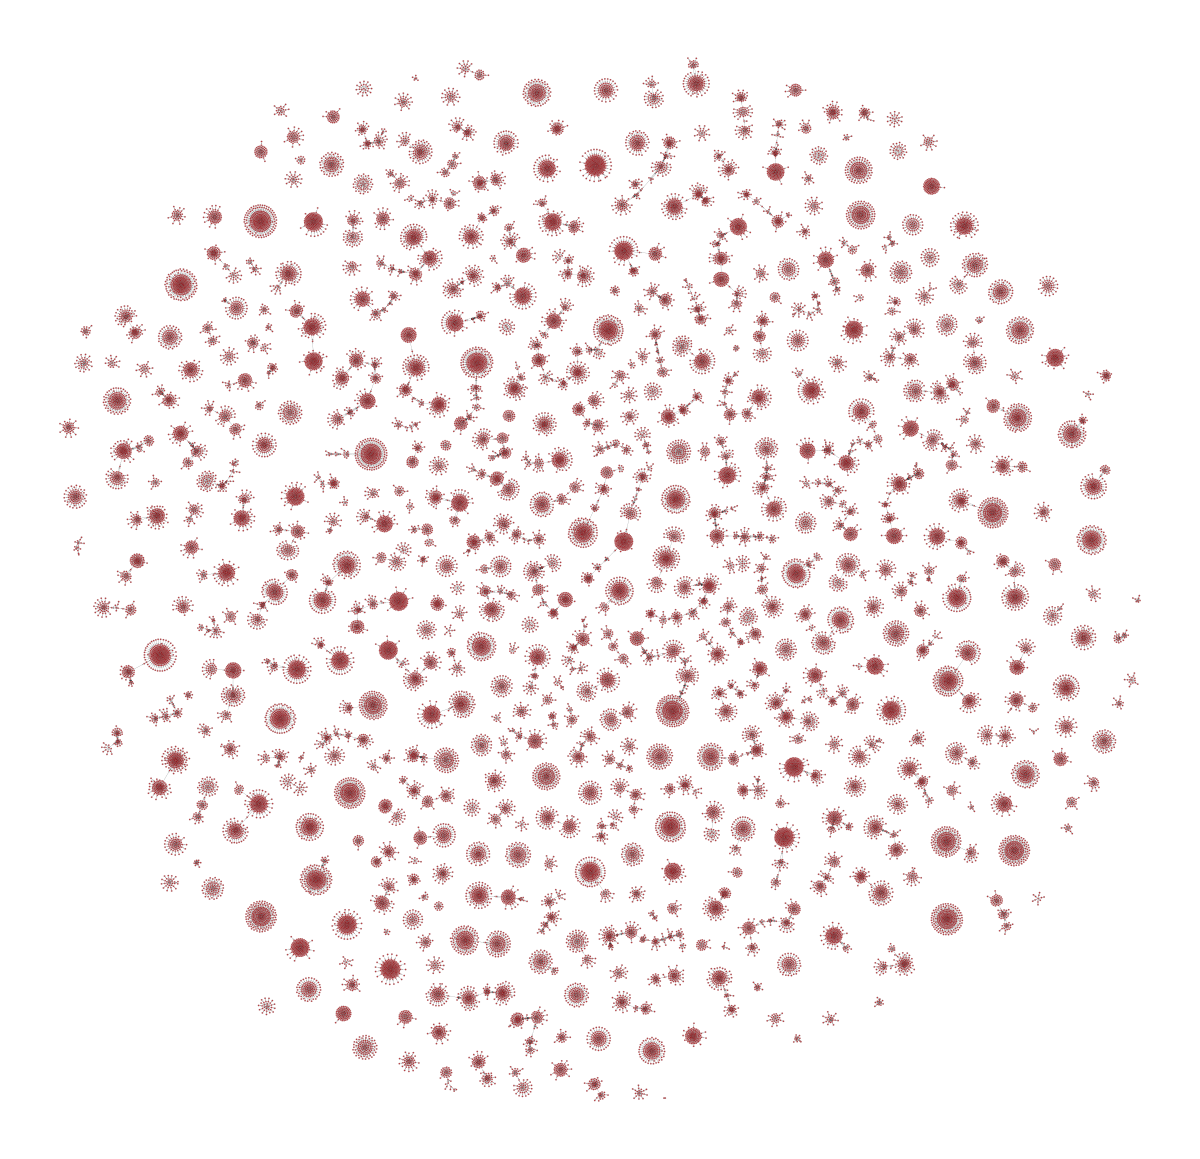

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8080d926d0, at 0x7f80c4e34ca0>

In [36]:
G.num_vertices()
gt.graph_draw(G)

In [96]:
for v in G.vertices():
    print("Node", int(v), "has attrs:")
    for prop in G.vertex_properties:
        print("  -", prop, ":", G.vertex_properties[prop][v])

Node 0 has attrs:
  - pl_name : Throwbacks
  - pl_type : playlist
  - tr_uri : 
  - tr_name : 
  - tr_type : 
  - ar_uri : 
  - ar_name : 
  - ar_type : 
Node 1 has attrs:
  - pl_name : Awesome Playlist
  - pl_type : playlist
  - tr_uri : 
  - tr_name : 
  - tr_type : 
  - ar_uri : 
  - ar_name : 
  - ar_type : 
Node 2 has attrs:
  - pl_name : korean 
  - pl_type : playlist
  - tr_uri : 
  - tr_name : 
  - tr_type : 
  - ar_uri : 
  - ar_name : 
  - ar_type : 
Node 3 has attrs:
  - pl_name : mat
  - pl_type : playlist
  - tr_uri : 
  - tr_name : 
  - tr_type : 
  - ar_uri : 
  - ar_name : 
  - ar_type : 
Node 4 has attrs:
  - pl_name : 90s
  - pl_type : playlist
  - tr_uri : 
  - tr_name : 
  - tr_type : 
  - ar_uri : 
  - ar_name : 
  - ar_type : 
Node 5 has attrs:
  - pl_name : Wedding
  - pl_type : playlist
  - tr_uri : 
  - tr_name : 
  - tr_type : 
  - ar_uri : 
  - ar_name : 
  - ar_type : 
Node 6 has attrs:
  - pl_name : I Put A Spell On You
  - pl_type : playlist
  - tr_uri : 


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




  - ar_uri : spotify:artist:3pHeBYl1yujXcZqqfF1UyQ
  - ar_name : Blues Traveler
  - ar_type : artist
Node 69261 has attrs:
  - pl_name : 
  - pl_type : 
  - tr_uri : 
  - tr_name : 
  - tr_type : 
  - ar_uri : spotify:artist:78SHxLdtysAXgywQ4vE0Oa
  - ar_name : Bush
  - ar_type : artist
Node 69262 has attrs:
  - pl_name : 
  - pl_type : 
  - tr_uri : 
  - tr_name : 
  - tr_type : 
  - ar_uri : spotify:artist:3R6c2tWDBeYB1GncjLMn9n
  - ar_name : Candlebox
  - ar_type : artist
Node 69263 has attrs:
  - pl_name : 
  - pl_type : 
  - tr_uri : 
  - tr_name : 
  - tr_type : 
  - ar_uri : spotify:artist:0TcYeHEK9sBtv7xPbKhzHz
  - ar_name : Chumbawamba
  - ar_type : artist
Node 69264 has attrs:
  - pl_name : 
  - pl_type : 
  - tr_uri : 
  - tr_name : 
  - tr_type : 
  - ar_uri : spotify:artist:4e5V1Q2dKCzbLVMQ8qbTn6
  - ar_name : Collective Soul
  - ar_type : artist
Node 69265 has attrs:
  - pl_name : 
  - pl_type : 
  - tr_uri : 
  - tr_name : 
  - tr_type : 
  - ar_uri : spotify:artist:4e5

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

